<a href="https://colab.research.google.com/github/cevitaufik/Belajar-Pengembangan-Machine-Learning/blob/main/Submission_2_time_series_BTCUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Memprediksi harga BTCUSD**
<hr><br>
Nama : Cevi Taufik <br>
Email&nbsp;&nbsp;: cevitaufik@gmail.com

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [36]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [37]:
df = pd.read_csv('/content/gdrive/MyDrive/sample/kaggle/gemini_BTCUSD_2020_1min.csv')
df = df.drop(columns = ['Unix Timestamp', 'Symbol'])
df

,Date,Open,High,Low,Close,Volume
0,4/20/2021 0:02,55717.47,55723.00,55541.69,55541.69,2.406734
1,4/20/2021 0:01,55768.94,55849.82,55711.74,55717.47,0.573458
2,4/20/2021 0:00,55691.79,55793.15,55691.79,55768.94,3.309904
3,4/19/2021 23:59,55777.86,55777.86,55677.92,55691.79,0.684934
4,4/19/2021 23:58,55803.50,55823.88,55773.08,55777.86,0.477225
...,...,...,...,...,...,...
658060,1/1/2020 0:04,7163.60,7163.60,7163.00,7163.00,1.751844
658061,1/1/2020 0:03,7163.00,7163.60,7163.00,7163.60,0.002706
658062,1/1/2020 0:02,7163.30,7164.22,7163.00,7163.00,0.063904
658063,1/1/2020 0:01,7163.30,7164.23,7163.30,7163.30,0.002646


In [38]:
# mengurangi jumlah data menjadi hanya 40000
# untuk mempersingkat proses
df = df.drop(labels = range(0, 618000), axis = 0)
df

,Date,Open,High,Low,Close,Volume
618000,1/30/2020 19:42,9459.27,9459.27,9459.27,9459.27,0.000000
618001,1/30/2020 19:41,9460.42,9463.86,9457.25,9459.27,0.010936
618002,1/30/2020 19:40,9459.47,9472.85,9459.47,9460.42,21.048081
618003,1/30/2020 19:39,9455.76,9459.47,9455.76,9459.47,0.024210
618004,1/30/2020 19:38,9456.46,9465.31,9453.64,9455.76,1.244039
...,...,...,...,...,...,...
658060,1/1/2020 0:04,7163.60,7163.60,7163.00,7163.00,1.751844
658061,1/1/2020 0:03,7163.00,7163.60,7163.00,7163.60,0.002706
658062,1/1/2020 0:02,7163.30,7164.22,7163.00,7163.00,0.063904
658063,1/1/2020 0:01,7163.30,7164.23,7163.30,7163.30,0.002646


In [39]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

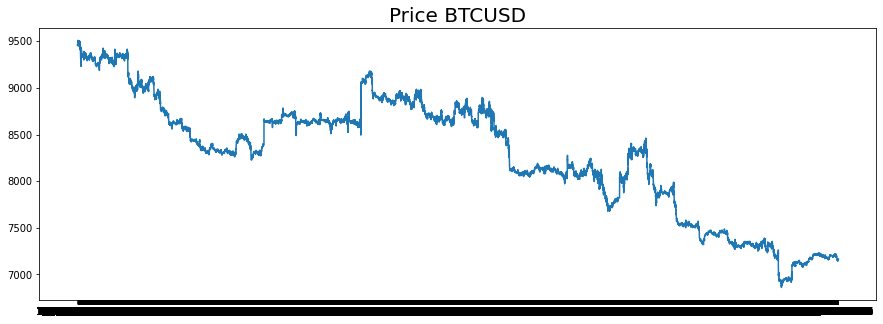

In [40]:
dates = df['Date'].values
price = df['Close'].values

plt.figure(figsize = (15,5))
plt.plot(dates, price)
plt.title('Price BTCUSD', fontsize = 20);

In [41]:
from sklearn.model_selection import train_test_split
dates_train, dates_test, price_train, price_test = train_test_split(dates, price, test_size = 0.2, random_state = 1)

In [42]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [43]:
train_set = windowed_dataset(price_train,
                             window_size = 60,
                             batch_size = 200,
                             shuffle_buffer = 1000)

test_set = windowed_dataset(price_test,
                             window_size = 60,
                             batch_size = 200,
                             shuffle_buffer = 1000)
 
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences = True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation = "relu"),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1),
])

In [44]:
targetAccuracy = 2200
 
class clbk(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('mae') < targetAccuracy):
      print("\nTarget akurasi telah tercapai!")
      self.model.stop_training = True
callback = clbk()

# lr = 1.0000e-04
lr = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
 
epoch = 100
batch = 128
history = model.fit(train_set,
                    batch_size = batch, 
                    epochs = epoch, 
                    callbacks = [callback],
                    validation_data = (test_set))

Epoch 1/100
160/160 [==============================] - 39s 219ms/step - loss: 17879.2266 - mae: 17879.7207 - val_loss: 8142.3999 - val_mae: 8142.8999
Epoch 2/100
160/160 [==============================] - 34s 214ms/step - loss: 8060.1782 - mae: 8060.6812 - val_loss: 7982.3994 - val_mae: 7982.8994
Epoch 3/100
160/160 [==============================] - 35s 215ms/step - loss: 7900.1816 - mae: 7900.6797 - val_loss: 7822.3989 - val_mae: 7822.8994
Epoch 4/100
160/160 [==============================] - 35s 216ms/step - loss: 7740.1812 - mae: 7740.6807 - val_loss: 7662.3984 - val_mae: 7662.8984
Epoch 5/100
160/160 [==============================] - 35s 215ms/step - loss: 7580.1797 - mae: 7580.6812 - val_loss: 7502.3984 - val_mae: 7502.8979
Epoch 6/100
160/160 [==============================] - 34s 214ms/step - loss: 7420.1782 - mae: 7420.6792 - val_loss: 7342.3999 - val_mae: 7342.8989
Epoch 7/100
160/160 [==============================] - 35s 215ms/step - loss: 7260.1816 - mae: 7260.6816 - val

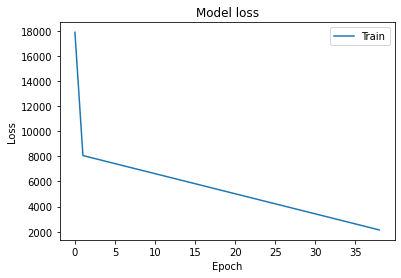

In [45]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper right')
plt.show()

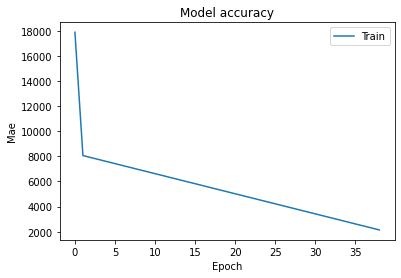

In [46]:
plt.plot(history.history['mae'])
plt.title('Model accuracy')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper right')
plt.show()